# Bayesian Optimization

## Setup custom stuff for the colab (packages, data)

In [0]:
!pip install gpflow
import sys
import os

Cloning into 'chemistry_ml_colab'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 109 (delta 36), reused 87 (delta 18), pack-reused 0
Receiving objects: 100% (109/109), 8.18 MiB | 13.40 MiB/s, done.
Resolving deltas: 100% (36/36), done.
--2019-05-21 21:03:22--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70348401 (67M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  67.09M   197MB/s    in 0.3s    

2019-05-21 21:03:22 (197 MB/s) - ‘Miniconda3-latest-Linux-x86_64.sh’ saved [70348401/70348401]

PREFIX=/usr/local
reinstalling: python-3.7.3-h0371630_0 

=========================== Your current files are: ============================
custom_packages.py  data  images  LICENSE  README.md


## Import libraries


In [0]:
from collections import OrderedDict

# tqdm for a progress bar
from tqdm import tqdm
# scientific python stack
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ML/DL
import sklearn
import sklearn.model_selection
import sklearn.metrics
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
import gpflow 
print('Tensorflow:{}'.format(tf.__version__))
print('Keras:{}'.format(keras.__version__))
print('gpflow:{}'.format(gpflow.__version__))

RDKit:2019.03.2
Tensorflow:1.13.1
Keras:2.2.4-tf
Pytorch:1.1.0
gpflow:1.3.0


## How to tune the best architecture

![](https://github.com/beangoben/chemistry_ml_colab/blob/master/images/bayesopt.gif?raw=true)


* https://github.com/fmfn/BayesianOptimization/blob/master/examples/visualization.ipynb
* https://github.com/SheffieldML/GPyOpt
* https://github.com/automl/pysmac
* http://sheffieldml.github.io/GPyOpt/

In [0]:
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction
from matplotlib import gridspec
def posterior(optimizer, x_obs, y_obs, grid):
    optimizer._gp.fit(x_obs, y_obs)

    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma

def plot_gp(optimizer, x, y):
    fig = plt.figure(figsize=(16, 10))
    steps = len(optimizer.space)
    fig.suptitle(
        'Gaussian Process and Utility Function After {} Steps'.format(steps),
        fontdict={'size':30}
    )
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    x_obs = np.array([[res["params"]["x"]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])
    
    mu, sigma = posterior(optimizer, x_obs, y_obs, x)
    axis.plot(x, y, linewidth=3, label='Target')
    axis.plot(x_obs.flatten(), y_obs, 'D', markersize=8, label=u'Observations', color='r')
    axis.plot(x, mu, '--', color='k', label='Prediction')

    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval')
    
    axis.set_xlim((-2, 10))
    axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})
    
    utility_function = UtilityFunction(kind="ucb", kappa=5, xi=0)
    utility = utility_function.utility(x, optimizer._gp, 0)
    acq.plot(x, utility, label='Utility Function', color='purple')
    acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    acq.set_xlim((-2, 10))
    acq.set_ylim((0, np.max(utility) + 0.5))
    acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel('x', fontdict={'size':20})
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

## black box function

In [0]:
def target(x):
    return np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1/ (x**2 + 1)

### lets take a gander

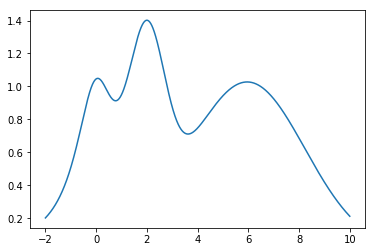

In [0]:
x = np.linspace(-2, 10, 10000).reshape(-1, 1)
y = target(x)

plt.plot(x, y)
plt.show()

In [0]:
optimizer = BayesianOptimization(target, {'x': (-2, 10)})
optimizer.maximize(init_points=0, n_iter=0, kappa=5)

|   iter    |  target   |     x     |
-------------------------------------
|  1        |  0.924    |  7.004    |


## Iterative

|   iter    |  target   |     x     |
-------------------------------------
|  11       |  0.6769   | -0.7094   |


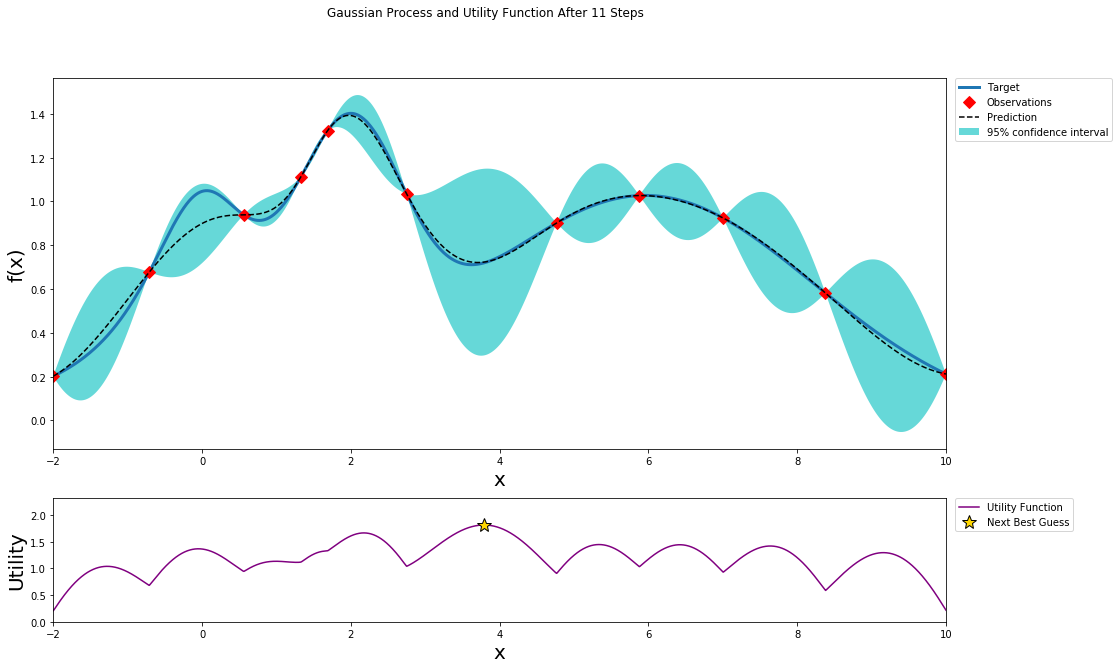

In [0]:
optimizer.maximize(init_points=0, n_iter=1, kappa=5)
plot_gp(optimizer, x, y)